In [1]:
import anndata
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from scipy import sparse, io

#also need: igraph, leidenalg

matplotlib.rcParams.update({'font.size': 12})

# Load in Data
We are using single-cell RNA sequencing (scRNA-seq) data. scRNA-seq is a popular technique for measuring gene expression at the single-cell level.

**The Technique:**
- Individual cells are isolated and captured
- RNA is extracted from each cell, converted to complementary DNA (cDNA), and amplified
- the cDNA libraries are sequenced to generate the transcriptome of each cell - which genes are expressed at at which levels

**The Data:**
- Gene expression matrix: the expression levels of genes in individual cells. Each row is a gene and each column is a cell.
- Barcodes: each cell is associated with a unique barcode that allows researchers to track expression profiles back to specific cells
- Genes: Information about genes detected in the cells (names, identifiers, expression levels)

## [Ischemic Stroke Data](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE174574)

In [2]:
# Load in stroke data sample 1: MCA01

# Load the data into an AnnData object
adata_stroke1 = anndata.read_mtx("stroke_data/GSM5319990_MCAO1_matrix.mtx.gz") # genes by cells matrix

# Read the barcode and gene files
barcodes_stroke1 = pd.read_csv("stroke_data/GSM5319990_MCAO1_barcodes.tsv.gz", header=None)
genes_stroke1 = pd.read_csv("stroke_data/GSM5319990_MCAO1_genes.tsv.gz", header=None)

In [3]:
# Set the barcodes and genes as row and column names for MCA01
adata_stroke1.obs_names = genes_stroke1[0]
adata_stroke1.var_names = barcodes_stroke1[0]

In [4]:
# Transpose the matrix so that it is a cells by genes matrix
adata_stroke1 = adata_stroke1.transpose()

In [5]:
# Load in stroke control data sample 1: sham1

# Load the data into an AnnData object
adata_sham1 = anndata.read_mtx("stroke_data/GSM5319987_sham1_matrix.mtx.gz") # genes by cells matrix

# Read the barcode and gene files
barcodes_sham1 = pd.read_csv("stroke_data/GSM5319987_sham1_barcodes.tsv.gz", header=None)
genes_sham1 = pd.read_csv("stroke_data/GSM5319987_sham1_genes.tsv.gz", header=None)

In [6]:
# Set the barcodes and genes as row and column names for sham1
adata_sham1.obs_names = genes_sham1[0]
adata_sham1.var_names = barcodes_sham1[0]

In [7]:
# Transpose the matrix so that it is a cells by genes matrix
adata_sham1 = adata_sham1.transpose()

# Basic Quality Control
Inspired by https://www.kallistobus.tools/tutorials/kb_getting_started/python/kb_intro_2_python/#examine-the-knee-plot

## Represent the Cells in 2D via Singular Value Decomposition
We're currently working in very high-dimensional gene expression space. We want to transform it to a lower-dimensional space defined by the top singular vectors to capture the most significant patterns of variation while not getting distracted by noise.

SVD decomposes a matrix into 3 matrices:
- U: Left singular vectors, representing the basis vectors for the rows/cells
- S: A diagonal matrix of singular values, which represent the importance of each basis vector for rows/cells
- V: Right singular vectors, representing the basis vectors for columns/genes

We'll use TruncatedSVD, a variant that computes only the top singular vectors, which is more computationally efficient for large matrices.

(PCA, which we saw in class, is a specific application of SVD to the covariance matrix of the data.)

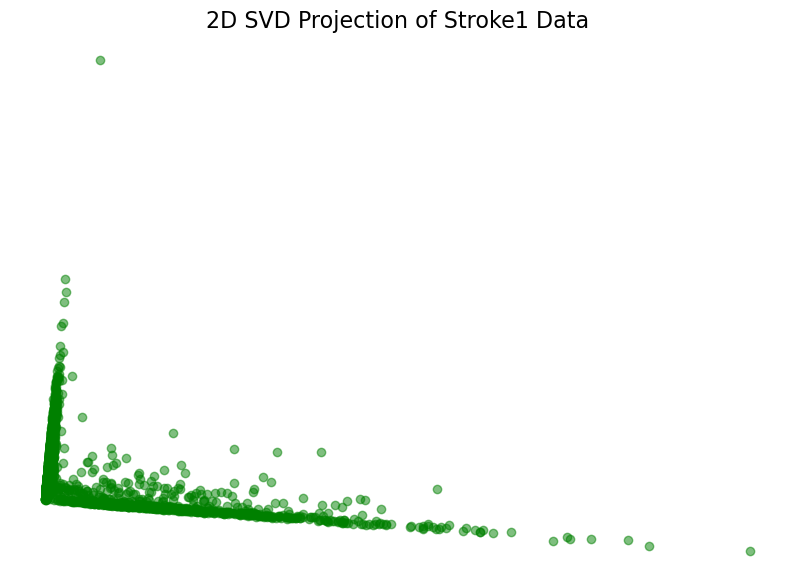

In [8]:
# Perform SVD on Stroke1
tsvd_stroke1 = TruncatedSVD(n_components=2)
tsvd_stroke1.fit(adata_stroke1.X)
X_stroke1 = tsvd_stroke1.transform(adata_stroke1.X)

# Plot Strok1 SVD components
fig, ax = plt.subplots(figsize=(10, 7))

ax.scatter(X_stroke1[:,0], X_stroke1[:,1], alpha=0.5, c="green")

ax.set_title('2D SVD Projection of Stroke1 Data', fontsize=16)

plt.axis('off')
plt.show()

## Test for Library Saturation
Library saturation is the point at which the sequencing depth is sufficient to capture the majority of expressed genes in each cell. (The point at which increasing the number of transcripts detected in each cell (the unique molecular identifier/UMI counts) does not result in a proportional increase in the number of genes detected.) If we have not "saturated" our sequencing library then increasing the number of UMI counts (x-axis) will not yield an appreciable increase in the number of genes detected (y-axis).

This is important for quality control because it will help us identify cells with low RNA content or other technical issues, which we should filter out.

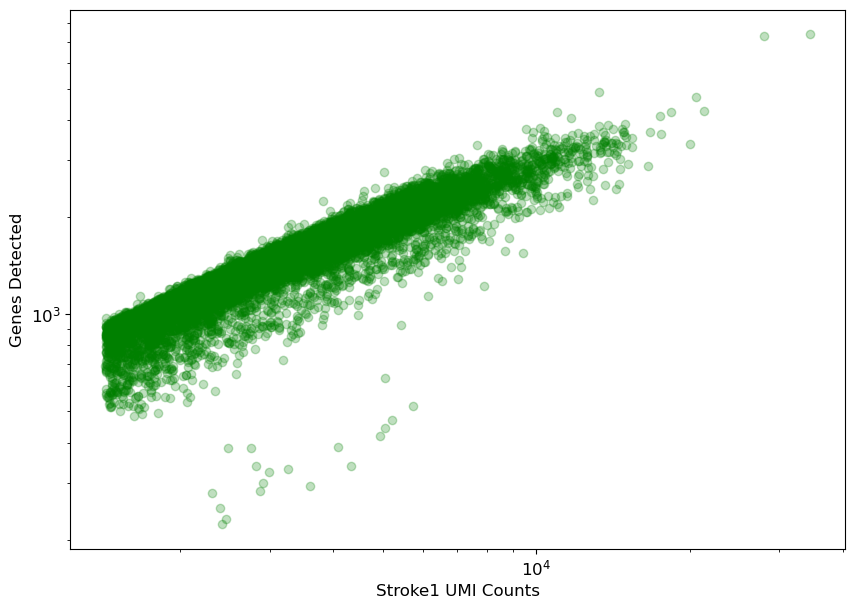

In [9]:
# Create a plot showing genes detected as a function of UMI counts.
fig, ax = plt.subplots(figsize=(10, 7))

x_stroke1 = np.asarray(adata_stroke1.X.sum(axis=1))[:,0]
y_stroke1 = np.asarray(np.sum(adata_stroke1.X>0, axis=1))[:,0]

ax.scatter(x_stroke1, y_stroke1, color="green", alpha=0.25)
ax.set_xlabel("Stroke1 UMI Counts")
ax.set_ylabel("Genes Detected")
ax.set_xscale('log')
ax.set_yscale('log')

plt.show()

## Examine the knee plot
"In this plot cells are ordered by the number of UMI counts associated to them (shown on the x-axis), and the fraction of droplets with at least that number of cells is shown on the y-axis. The idea is that "real" cells have a certain number of UMI counts and that a threshold on the UMI counts filters those cells."

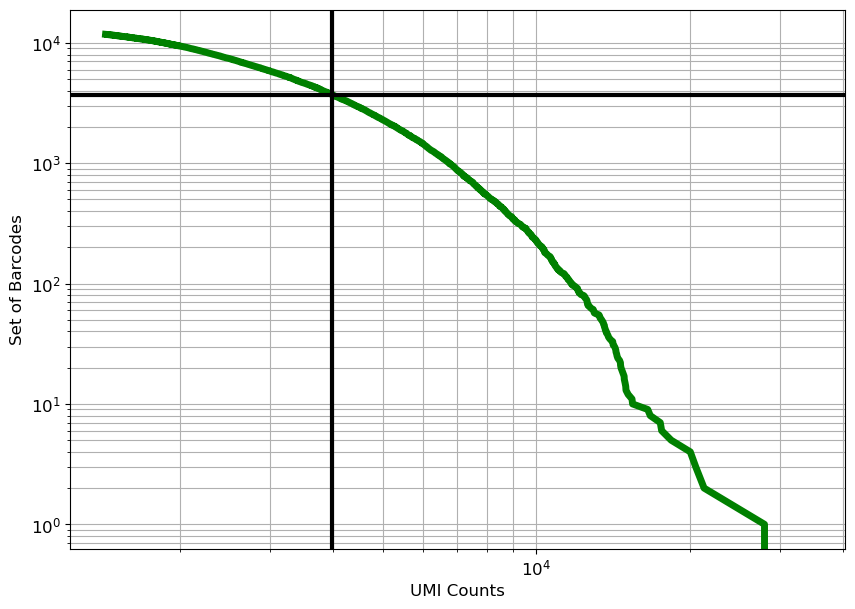

In [10]:
cutoff = 3979
knee = np.sort((np.array(adata_stroke1.X.sum(axis=1))).flatten())[::-1]
cell_set = np.arange(len(knee))
num_cells = cell_set[knee > cutoff][::-1][0]

fig, ax = plt.subplots(figsize=(10, 7))

ax.loglog(knee, cell_set, linewidth=5, color="g")
ax.axvline(x=cutoff, linewidth=3, color="k")

ax.axhline(y=num_cells, linewidth=3, color="k")

ax.set_xlabel("UMI Counts")
ax.set_ylabel("Set of Barcodes")

plt.grid(True, which="both")
plt.show()

In [11]:
print(f"{num_cells:,.0f} cells passed the {cutoff} UMI threshold")

3,704 cells passed the 3979 UMI threshold


## Filter empty droplets
Filter the cells according to the threshold determined from the knee plot

In [12]:
sc.pp.filter_cells(adata_stroke1, min_genes=3979)
# sc.pp.filter_cells(adata_stroke1, min_counts=knee[3704])
adata_stroke1

AnnData object with n_obs × n_vars = 9 × 27998
    obs: 'n_genes'